In [13]:
# naive approach
"""
Cadereyta refineria: 
Petróleo y petroquímica	51.95%	99.88%	8625.4

Zinc Nacional:
Química	40.16%	99.66%	6667.6

luego hacer de que la proporcion de veces que el viento en nuestros datos fue barlovento y sotavento.

primero, dado un mapa de viento y asi generar un vector con el orden (distancia y tiempo) en el que llegaria una cierta concentracion

suposiciones:
- mientras más cerca, más concentración, y eso significa para nosotros un mayr impacto del foco de emisión.
- solo 2 focos nos son relevantes, los demás son negligible.
- tomamos el movimiento del viento a una misma altura.
- tomamos la dinámica del viento bidimensionalmente..
- esta


Podria explicarlo de dos maneras diferentes:
- cual tiene mas impacto meramente por el hecho de que los vientos en las temporalidades usadas ha beneficiado más a una que a otra.
- solo contar cuando esta a sotavento


Limitaciones y propuestas de mejora del approach tomado
- utilizar lags.
- que deje de ser bidimensional
- que se haga maz y mas pequeño el grid de viento, aumentando su exactitud.
- asume que el viento no cambia en un dia
"""

'\nCadereyta refineria: \nPetróleo y petroquímica\t51.95%\t99.88%\t8625.4\n\nZinc Nacional:\nQuímica\t40.16%\t99.66%\t6667.6\n\nluego hacer de que la proporcion de veces que el viento en nuestros datos fue barlovento y sotavento.\n\nprimero, dado un mapa de viento y asi generar un vector con el orden (distancia y tiempo) en el que llegaria una cierta concentracion\n\nsuposiciones:\n- mientras más cerca, más concentración, y eso significa para nosotros un mayr impacto del foco de emisión.\n- solo 2 focos nos son relevantes, los demás son negligible.\n- tomamos el movimiento del viento a una misma altura.\n- tomamos la dinámica del viento bidimensionalmente..\n- esta\n\n\nPodria explicarlo de dos maneras diferentes:\n- cual tiene mas impacto meramente por el hecho de que los vientos en las temporalidades usadas ha beneficiado más a una que a otra.\n- solo contar cuando esta a sotavento\n\n\nLimitaciones y propuestas de mejora del approach tomado\n- utilizar lags.\n- que deje de ser bidim

In [14]:
import pandas as pd

# --- Leer CSV ---
df = pd.read_csv('base_final_sin_imputar_por_zona.csv',
                 parse_dates=['date'],
                 infer_datetime_format=True)

# --- Validar columnas requeridas ---
required = {'Zona', 'date', 'SO2'}
if not required.issubset(df.columns):
    missing = required - set(df.columns)
    raise ValueError(f"Faltan columnas en el CSV: {missing}")

# --- Pivotar: filas = fechas, columnas = zonas, valores = SO2 ---
df_wide = df.pivot_table(index='date', columns='Zona', values='SO2', aggfunc='mean')

# --- Ordenar por fecha y limpiar ---
df_wide = df_wide.sort_index().reset_index()

# --- Verificación ---
print("Columnas (zonas):", list(df_wide.columns))
print(df_wide.head())

C:\Users\Andre\AppData\Local\Temp\ipykernel_31204\2397463878.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('base_final_sin_imputar_por_zona.csv',


Columnas (zonas): ['date', 'CENTRO', 'NORESTE', 'NORESTE2', 'NORESTE3', 'NOROESTE', 'NOROESTE2', 'NOROESTE3', 'NORTE', 'NORTE2', 'SUR', 'SURESTE', 'SURESTE2', 'SURESTE3', 'SUROESTE', 'SUROESTE2']
Zona                date  CENTRO  NORESTE  NORESTE2  NORESTE3  NOROESTE  \
0    2020-01-01 01:00:00     NaN      0.9       NaN       NaN       NaN   
1    2020-01-01 02:00:00     NaN      1.5       NaN       NaN       NaN   
2    2020-01-01 03:00:00     2.9      1.5       NaN       NaN       NaN   
3    2020-01-01 04:00:00     3.3      1.1       NaN       NaN       NaN   
4    2020-01-01 05:00:00     3.2      0.7       NaN       NaN       NaN   

Zona  NOROESTE2  NOROESTE3  NORTE  NORTE2  SUR  SURESTE  SURESTE2  SURESTE3  \
0           NaN        NaN    NaN    18.6  NaN      5.4       NaN       NaN   
1           NaN        NaN    NaN    18.9  NaN      5.5      11.0       NaN   
2           NaN        NaN    NaN    19.1  NaN      5.4      11.0       NaN   
3           NaN        NaN    NaN    

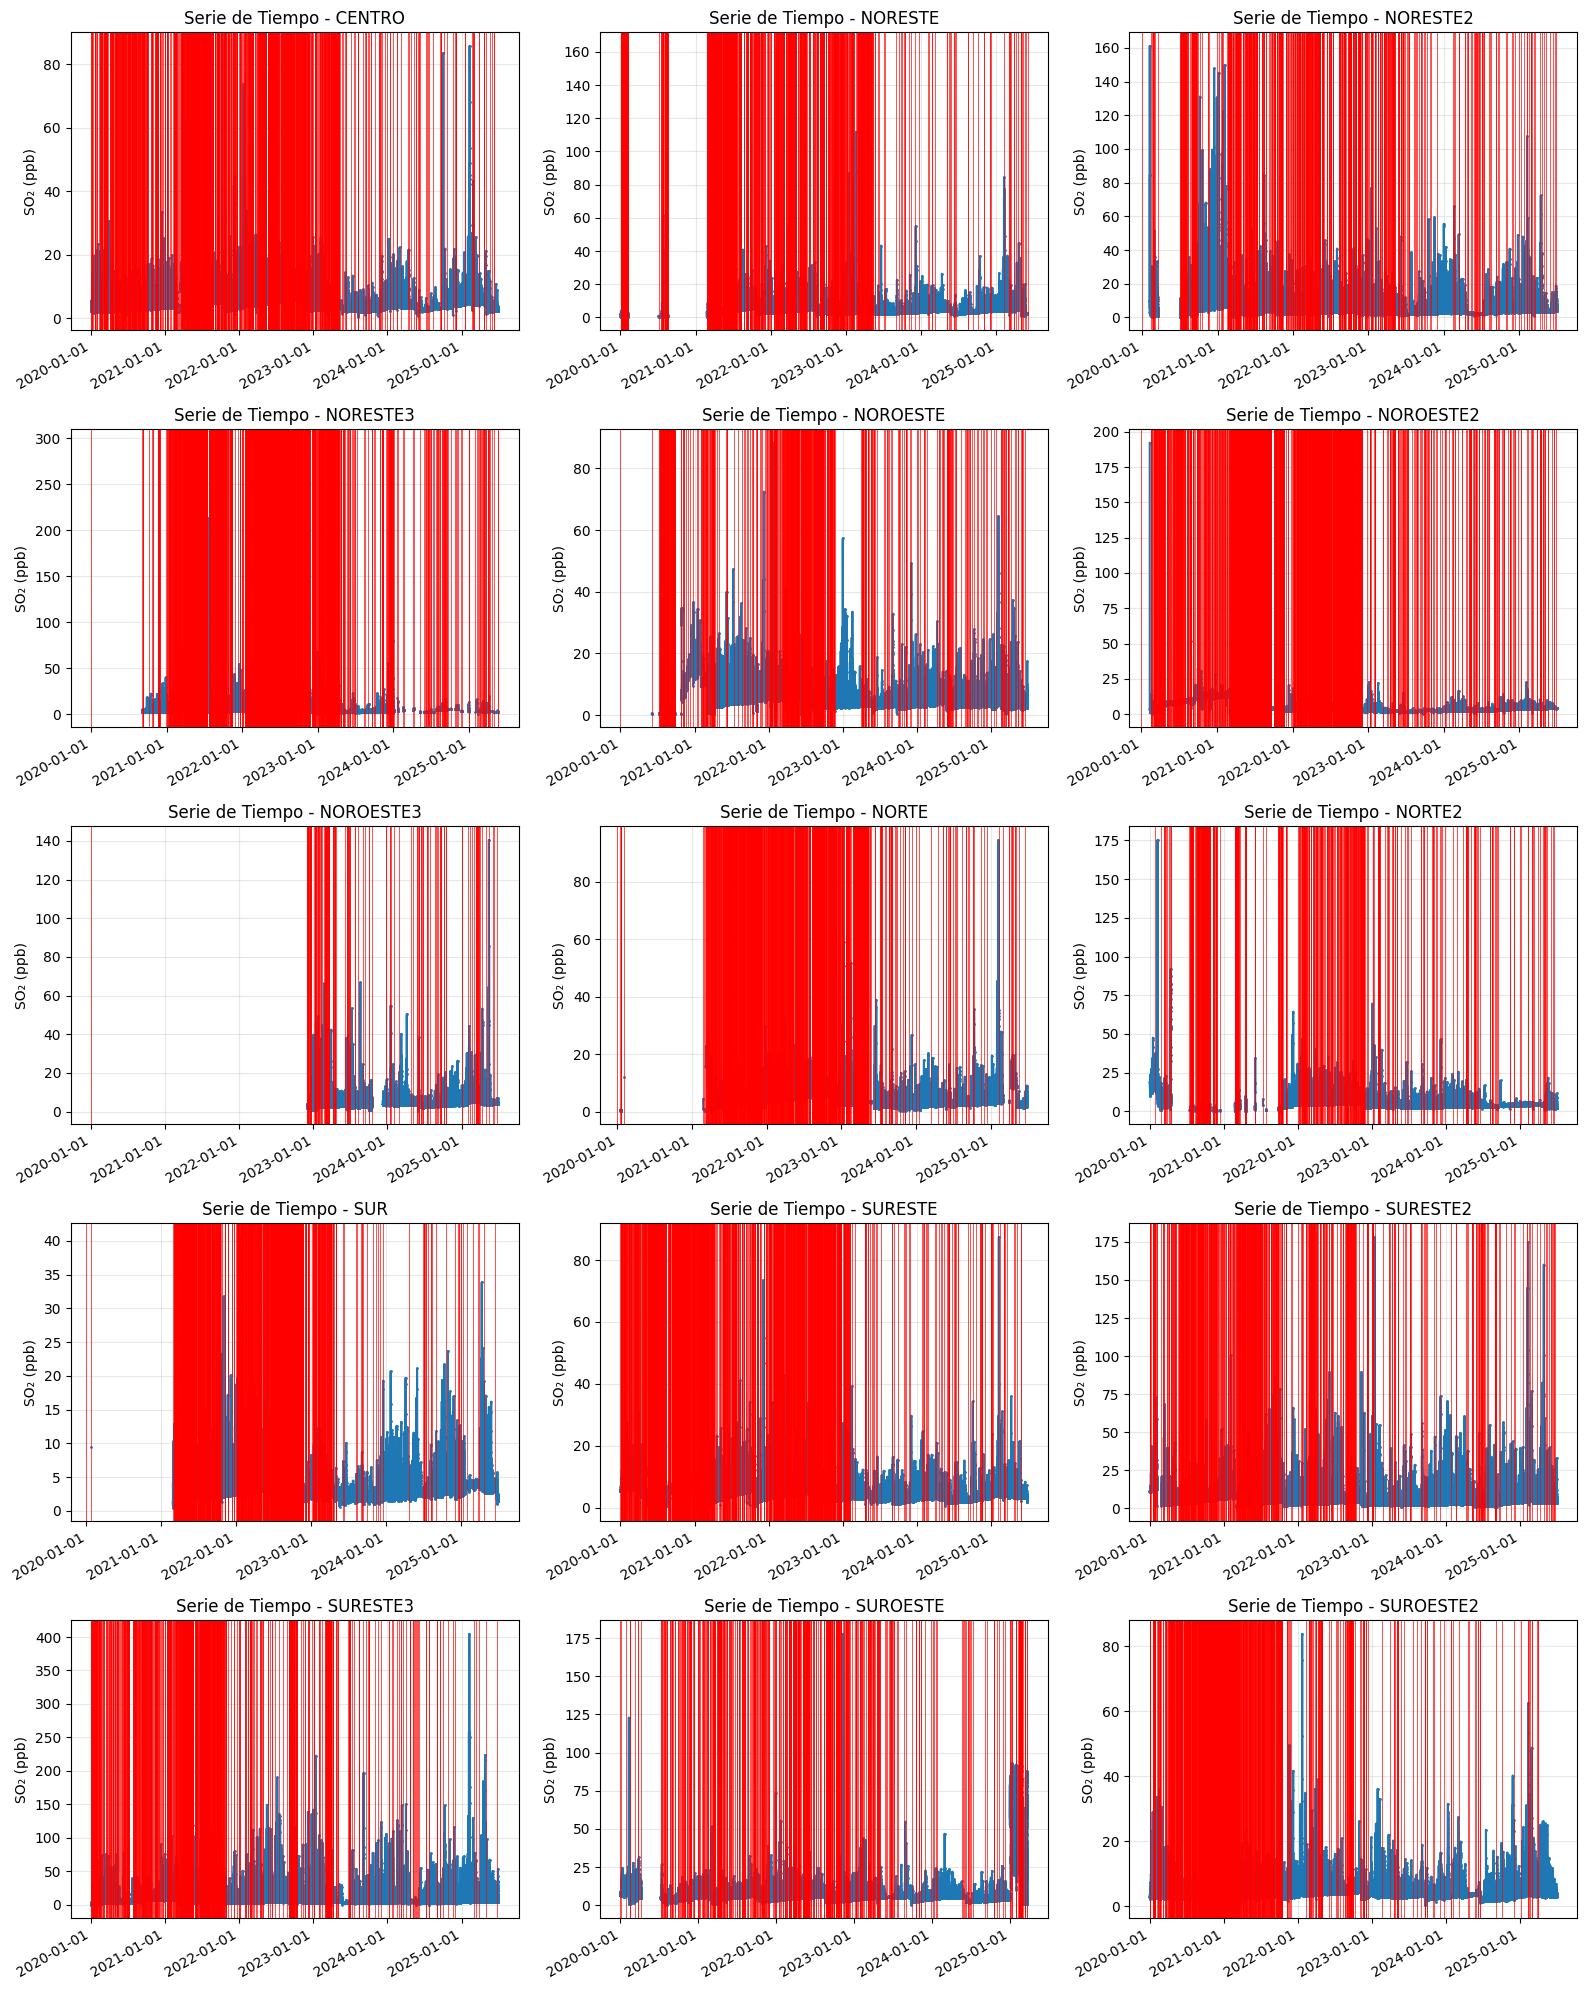

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# df_wide debe tener esta forma:
# | date | CENTRO | NORTE | SUR | ... |
zones = [c for c in df_wide.columns if c != 'date']

ncols = 3
nrows = int(np.ceil(len(zones) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows), sharex=False)
axs = axs.flatten()

for i, zona in enumerate(zones):
    ax = axs[i]
    x = df_wide['date']
    y = df_wide[zona]

    # Serie temporal
    ax.plot(x, y, linestyle='-', marker='.', markersize=2, color='C0')
    ax.set_title(f"Serie de Tiempo - {zona}")
    ax.set_ylabel('SO₂ (ppb)')
    ax.grid(alpha=0.3)

    # Marcar NaNs con líneas rojas
    nan_mask = y.isna()
    nan_times = x[nan_mask]

    if len(nan_times) > 500:
        # Detectar inicios de secuencias de NaNs
        is_nan = nan_mask.to_numpy()
        dates = x.to_numpy()
        starts = []
        in_run = False
        for j, flag in enumerate(is_nan):
            if flag and not in_run:
                starts.append(dates[j])
                in_run = True
            elif not flag and in_run:
                in_run = False
        # Dibujar una línea por cada inicio de secuencia de NaNs
        for t in starts:
            ax.axvline(t, color='red', alpha=0.8, linewidth=0.6)
    else:
        for t in nan_times:
            ax.axvline(t, color='red', alpha=0.8, linewidth=0.6)

    # Formateo de fechas
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')

# Ocultar ejes sobrantes si hay menos zonas que subplots
for j in range(len(zones), len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()

In [16]:
# Contar timestamps originalmente
print("Número de timestamps originalmente:", len(df_wide))

# Filtrar filas donde TODAS las estaciones (excepto la columna 'date') tienen valores no NaN
valid_mask = df_wide.drop(columns='date').notna().all(axis=1)
df_valid = df_wide[valid_mask].reset_index(drop=True)

# Contar cuántos quedan
print("Número de timestamps válidos en todas las estaciones:", len(df_valid))

# (Opcional) mostrar rango de fechas válidas
print("Rango temporal válido:", df_valid['date'].min(), "→", df_valid['date'].max())


Número de timestamps originalmente: 48132
Número de timestamps válidos en todas las estaciones: 5840
Rango temporal válido: 2022-12-01 01:00:00 → 2025-02-26 09:00:00


In [17]:
import pandas as pd
import numpy as np

# --- CONFIGURACIÓN DE RANGOS ---
MFG_RANGES = {"SO2": (0, 500)}  # límites del fabricante
OP_RANGES = {
    2020: {"SO2": (0, 200)},
    2021: {"SO2": (0, 300)},
    2022: {"SO2": (0, 200)},
    2023: {"SO2": (0, 250)},
    2024: {"SO2": (0, 150)},
    2025: {"SO2": (0, 405)},
}

# ==========================================================
# 1️⃣  FILTRAR HORAS ENTRE 8 PM Y 6 AM
# ==========================================================
night_hours = list(range(0, 6)) + [20, 21, 22, 23]
mask_night = df_wide['date'].dt.hour.isin(night_hours)

# Filtrar timestamps válidos (sin NaN en ninguna estación)
mask_complete = df_wide.drop(columns='date').notna().all(axis=1)

# Aplicar filtros
df_night = df_wide[mask_night & mask_complete].reset_index(drop=True)

print(f"[1] Timestamps nocturnos (20–5h): {len(df_night)}")
if not df_night.empty:
    print(f"    Rango temporal: {df_night['date'].min()} → {df_night['date'].max()}")

# ==========================================================
# 2️⃣  FILTRAR POR RANGOS (MFG + OPERACIÓN)
# ==========================================================

df_filtered = df_night.copy()
df_filtered['year'] = df_filtered['date'].dt.year
so2_cols = [c for c in df_filtered.columns if c not in ['date', 'year']]

# Función auxiliar: obtener límites efectivos del año
def _limits_for_year(y):
    mfg_min, mfg_max = MFG_RANGES['SO2']
    if y in OP_RANGES and 'SO2' in OP_RANGES[y]:
        op_min, op_max = OP_RANGES[y]['SO2']
        low = max(mfg_min, op_min)
        high = min(mfg_max, op_max)
    else:
        low, high = mfg_min, mfg_max
    return low, high

# Aplicar límites año por año
for col in so2_cols:
    low_s = df_filtered['year'].map(lambda y: _limits_for_year(y)[0])
    high_s = df_filtered['year'].map(lambda y: _limits_for_year(y)[1])
    mask_out = (df_filtered[col] < low_s) | (df_filtered[col] > high_s)
    if mask_out.any():
        print(f"[2] {col}: {mask_out.sum()} valores fuera de rango → reemplazados con NaN")
        df_filtered.loc[mask_out, col] = np.nan

# ==========================================================
# 3️⃣  RESUMEN FINAL
# ==========================================================
mask_all_valid = df_filtered.drop(columns=['date', 'year']).notna().all(axis=1)
df_final = df_filtered[mask_all_valid].reset_index(drop=True)

print(f"[3] Total de filas tras filtrar rangos: {len(df_filtered)}")
print(f"[4] Timestamps completamente válidos (todas estaciones): {len(df_final)}")

if not df_final.empty:
    print(f"    Rango final: {df_final['date'].min()} → {df_final['date'].max()}")

df_final.head()

[1] Timestamps nocturnos (20–5h): 2380
    Rango temporal: 2022-12-01 01:00:00 → 2025-02-26 05:00:00
[3] Total de filas tras filtrar rangos: 2380
[4] Timestamps completamente válidos (todas estaciones): 2380
    Rango final: 2022-12-01 01:00:00 → 2025-02-26 05:00:00


Zona,date,CENTRO,NORESTE,NORESTE2,NORESTE3,NOROESTE,NOROESTE2,NOROESTE3,NORTE,NORTE2,SUR,SURESTE,SURESTE2,SURESTE3,SUROESTE,SUROESTE2,year
0,2022-12-01 01:00:00,2.0,2.1,3.0,3.5,3.3,2.2,2.2,2.5,2.7,1.5,2.6,1.8,2.4,6.9,2.6,2022
1,2022-12-01 02:00:00,2.2,2.1,2.2,3.5,3.7,2.2,2.1,2.6,2.6,1.5,2.8,1.8,2.3,6.2,3.1,2022
2,2022-12-01 21:00:00,2.5,2.0,3.0,3.2,3.0,2.9,2.0,2.8,2.4,1.9,2.5,2.4,2.5,5.0,3.2,2022
3,2022-12-01 22:00:00,2.6,2.2,3.1,3.5,2.8,3.1,2.2,2.6,2.4,1.7,2.3,2.1,2.3,4.4,3.2,2022
4,2022-12-01 23:00:00,2.6,2.0,2.3,3.8,2.8,2.9,2.1,2.7,2.4,1.7,2.2,2.0,2.3,4.5,3.1,2022


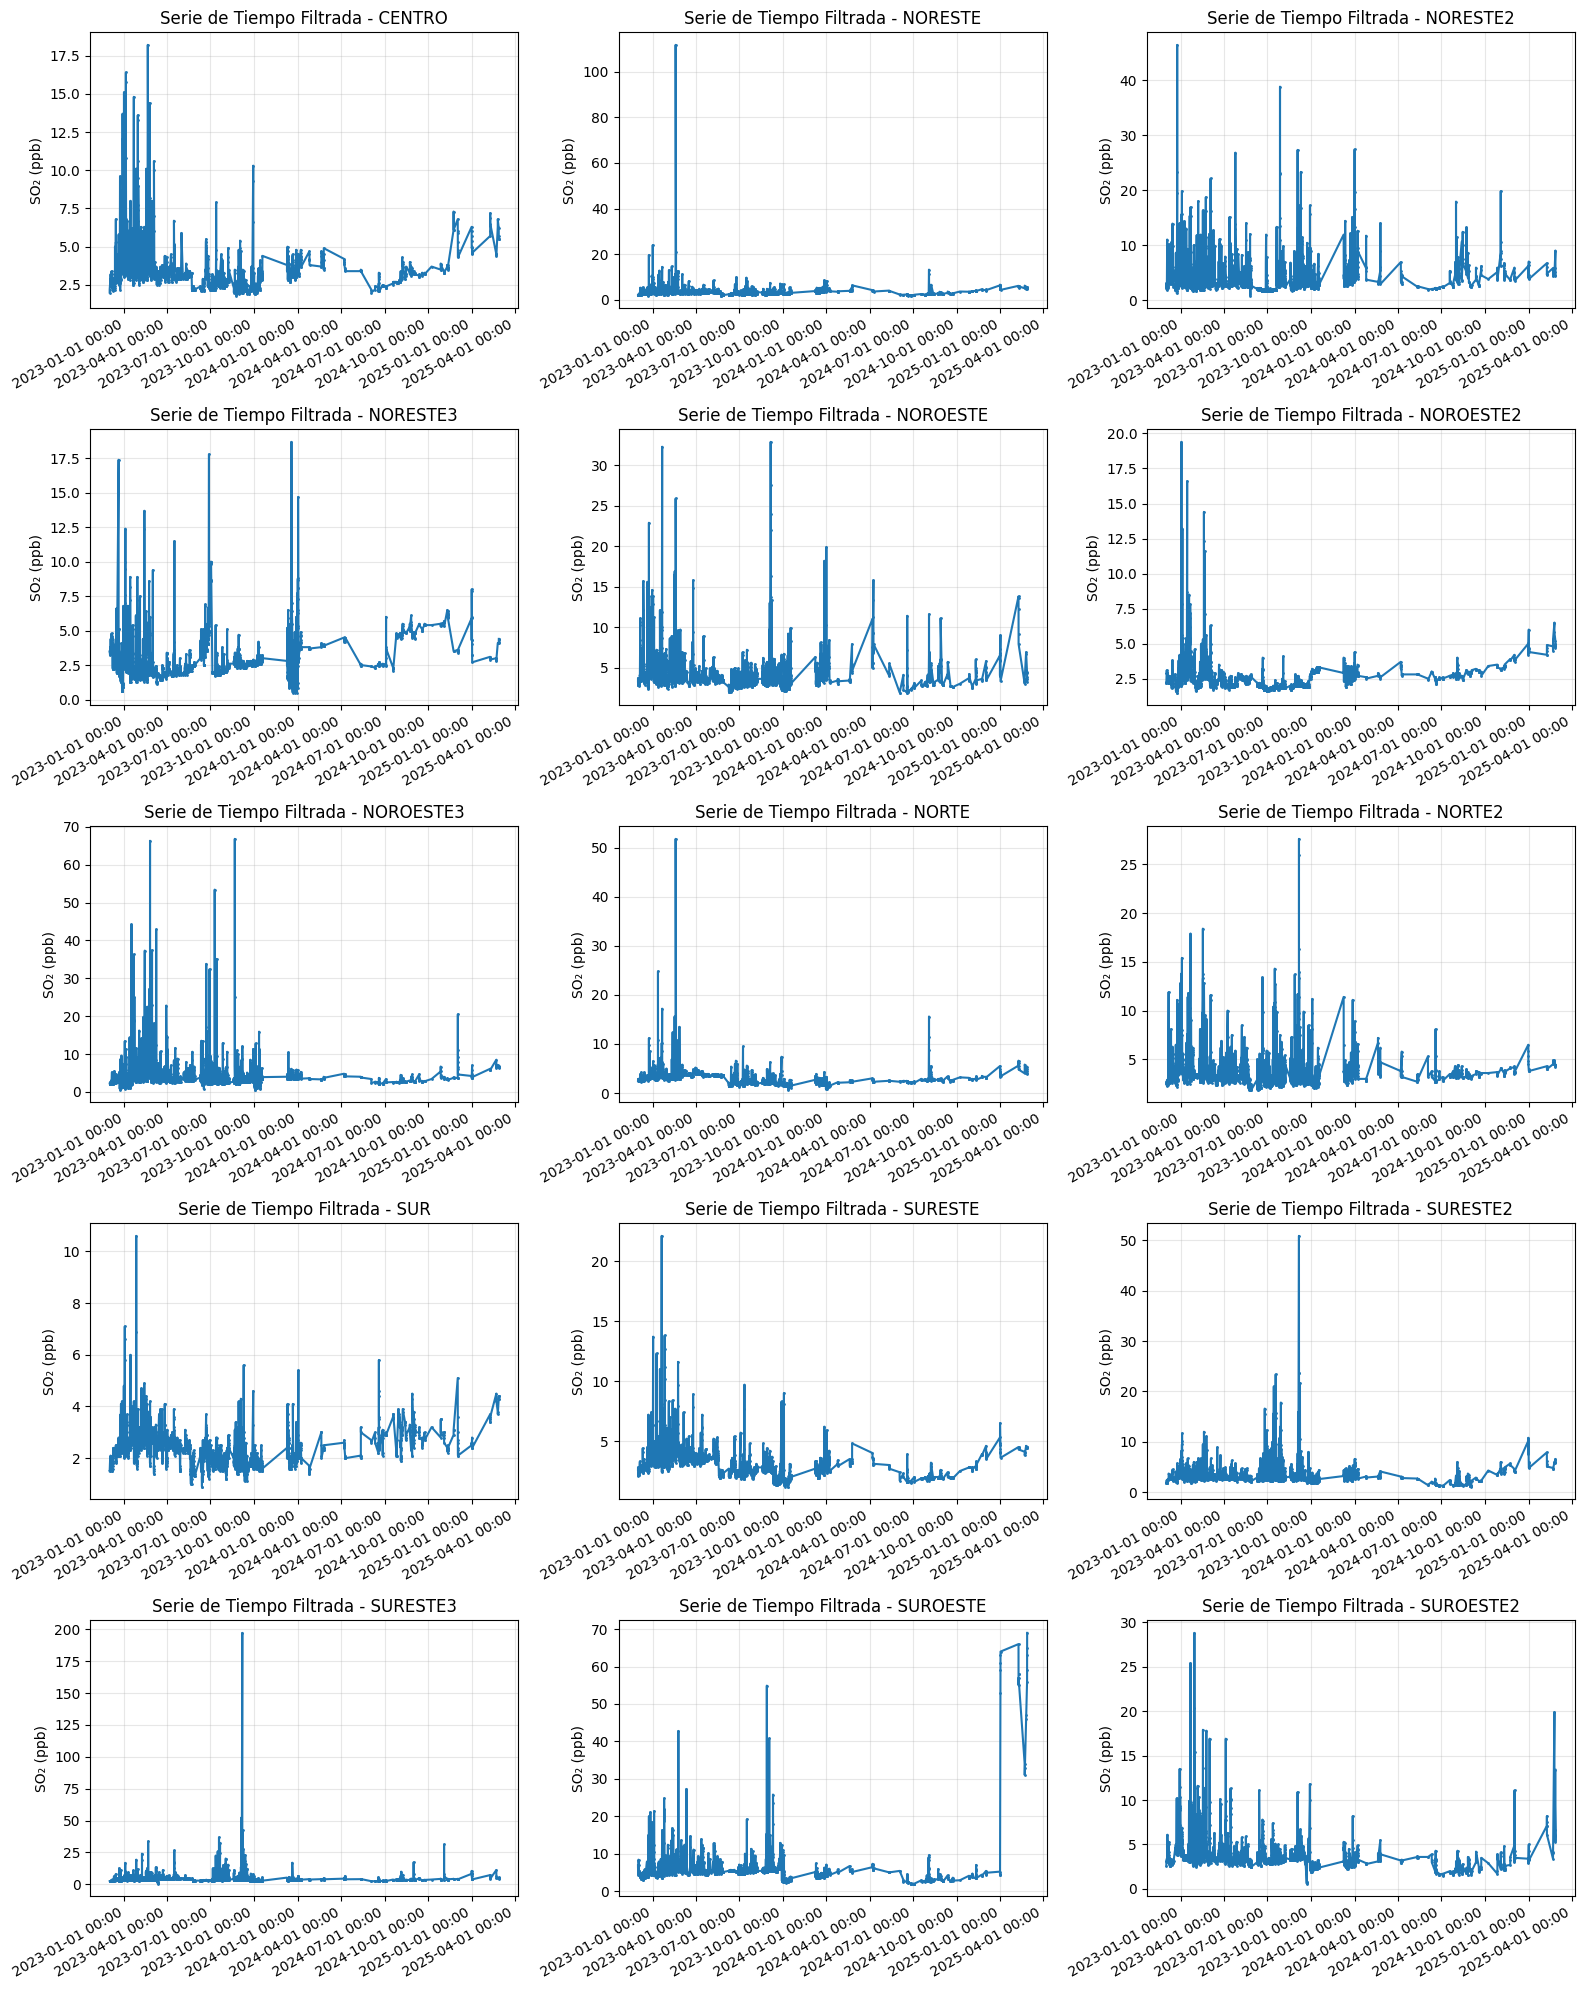

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Columnas de estaciones (todas menos 'date' y, por si acaso, 'year' si existiera)
zones = [c for c in df_final.columns if c not in ['date', 'year']]

ncols = 3
nrows = int(np.ceil(len(zones) / ncols)) if len(zones) > 0 else 1
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows), sharex=False)
axs = np.atleast_1d(axs).flatten()  # asegurar array 1D de ejes

for i, zona in enumerate(zones):
    ax = axs[i]
    x = df_final['date']
    y = df_final[zona]

    # Serie de tiempo
    ax.plot(x, y, linestyle='-', marker='.', markersize=2, color='C0')
    ax.set_title(f"Serie de Tiempo Filtrada - {zona}")
    ax.set_ylabel('SO₂ (ppb)')
    ax.grid(alpha=0.3)

    # Formato de fechas
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')

# Ocultar ejes sobrantes si hay menos zonas que subplots
for j in range(len(zones), len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()

In [24]:
import pandas as pd
import numpy as np
import requests, time, math, os
from datetime import timedelta

# ============================================================
# 🔧 UTILIDADES GEOGRÁFICAS Y DE VIENTO
# ============================================================

def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000
    dlat, dlon = math.radians(lat2 - lat1), math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def bearing_deg(lat1, lon1, lat2, lon2):
    dlon = math.radians(lon2 - lon1)
    y = math.sin(dlon) * math.cos(math.radians(lat2))
    x = (math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) -
         math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(dlon))
    ang = math.degrees(math.atan2(y, x))
    return (ang + 360) % 360

def ang_diff_deg(a, b):
    return abs((a - b + 180) % 360 - 180)

def count_downwind_for_focus(flat, flon, wd_from_deg, stations, theta_deg=30, v_ms=None, vmin=1.0):
    """Cuenta estaciones sotavento de un foco dado el viento local."""
    if v_ms is not None and (np.isnan(v_ms) or v_ms < vmin):
        return 0
    wd_to_deg = (wd_from_deg + 180) % 360
    cnt = 0
    for _, (slat, slon) in stations.items():
        rumbo = bearing_deg(flat, flon, slat, slon)
        if ang_diff_deg(rumbo, wd_to_deg) <= theta_deg:
            cnt += 1
    return cnt

# ============================================================
# 🔧 FUNCIONES PRINCIPALES
# ============================================================

def nearest_wind(lat, lon, df_wind):
    df_wind['dist'] = np.sqrt((df_wind['lat'] - lat)**2 + (df_wind['lon'] - lon)**2)
    return df_wind.loc[df_wind['dist'].idxmin()]

def travel_times_to_stations(flat, flon, stations, df_wind,
                             step_km=1.7, max_km=150, reach_km=8,
                             n_angles=9, angle_spread=25, turbulence_deg=5):
    """
    Densificación Lagrangiana: lanza múltiples trayectorias desde el foco,
    explorando un abanico angular (angle_spread) y con ruido turbulento (turbulence_deg).
    Retorna el tiempo mínimo de llegada por estación.
    """
    R = 6371000
    reached = {est: np.nan for est in stations.keys()}

    # viento base en el foco
    w_base = nearest_wind(flat, flon, df_wind)
    if np.isnan(w_base['windspeed']) or w_base['windspeed'] <= 0:
        return reached

    base_wd = w_base['winddir']
    base_ws = w_base['windspeed']

    # abanico de trayectorias centrado en el viento (hacia donde sopla)
    half = angle_spread / 2
    angle_offsets = np.linspace(-half, half, n_angles)

    for delta in angle_offsets:
        lat, lon = flat, flon
        t_total = 0

        for _ in range(int(max_km / step_km)):
            # viento local interpolado
            w_local = nearest_wind(lat, lon, df_wind)
            ws, wd = w_local['windspeed'], w_local['winddir']
            if np.isnan(ws) or ws <= 0:
                break

            # dirección hacia donde sopla + perturbación angular
            theta = (wd + 180 + delta + np.random.normal(0, turbulence_deg)) % 360
            theta_rad = math.radians(theta)

            dx = step_km * 1000 * math.sin(theta_rad)
            dy = step_km * 1000 * math.cos(theta_rad)
            dlat = (dy / R) * (180 / math.pi)
            dlon = (dx / (R * math.cos(math.radians(lat)))) * (180 / math.pi)
            lat += dlat
            lon += dlon
            t_total += (step_km * 1000) / ws / 3600  # horas

            # chequeo de estaciones alcanzadas
            for est, (slat, slon) in stations.items():
                d_to_est = haversine_m(lat, lon, slat, slon)
                if d_to_est <= reach_km * 1000:
                    if np.isnan(reached[est]) or t_total < reached[est]:
                        reached[est] = t_total

            if all(not np.isnan(v) for v in reached.values()):
                break

    return reached



# ============================================================
# 📍 COORDENADAS DE ESTACIONES Y FUENTES
# ============================================================

stations = {
    "SURESTE":   (25.665278, -100.243611),
    "NORESTE":   (25.744722, -100.253056),
    "CENTRO":    (25.675833, -100.338333),
    "NOROESTE":  (25.762778, -100.369167),
    "SUROESTE":  (25.675556, -100.458056),
    "NOROESTE2": (25.800278, -100.584444),
    "NORTE":     (25.798611, -100.327222),
    "NORTE2":    (25.729722, -100.310000),
    "NORESTE2":  (25.777222, -100.188056),
    "SUROESTE2": (25.665000, -100.412778),
    "SUR":       (25.616944, -100.273889),
    "NORESTE3":  (25.790556, -100.078333),
    "NOROESTE3": (25.768333, -100.463611),
    "SURESTE2":  (25.645833, -100.095278),
    "SURESTE3":  (25.601111, -99.999167)
}

sources = {
    "Refinería Cadereyta": (25.58890383518717, -99.94429923536717),
    "Zinc Nacional": (25.756029481005335, -100.32114422585992)
}

# ============================================================
# ⚙️ INICIALIZACIÓN DE ARCHIVO
# ============================================================

output_file = "tiempos_llegada_focos.csv"
if os.path.exists(output_file):
    df_result_global = pd.read_csv(output_file)
    processed_timestamps = df_result_global["timestamp"].unique()
    print(f"🔁 Archivo encontrado: {len(processed_timestamps)} timestamps procesados previamente.")
else:
    df_result_global = pd.DataFrame()
    processed_timestamps = []
    print("🆕 No existe archivo previo. Empezando desde cero.")

# ============================================================
# 🌬️ PARÁMETROS DEL GRID DE VIENTO
# ============================================================

lat_min, lat_max = 25.55, 25.80
lon_min, lon_max = -100.40, -100.00
n_lat, n_lon = 16, 16
lats = np.linspace(lat_min, lat_max, n_lat)
lons = np.linspace(lon_min, lon_max, n_lon)

# ============================================================
# ⏳ PROCESAR CADA TIMESTAMP (reusando viento cada 48h)
# ============================================================

df_final = df_final.sort_values("date")
timestamps = df_final["date"].unique()

df_wind_cache = None
last_wind_refresh = None

for current_ts in timestamps:
    if current_ts in processed_timestamps:
        continue

    current_time = pd.to_datetime(current_ts)
    fecha = current_time.strftime("%Y-%m-%d")
    hora = current_time.strftime("%H:00")

    # ---------------------------------------------------------
    # 🔁 Reusar viento cada 48 horas
    # ---------------------------------------------------------
    if df_wind_cache is None or (last_wind_refresh is None) or ((current_time - last_wind_refresh) >= timedelta(hours=48)):
        print(f"\n🌬️ Descargando nuevo campo de viento para {fecha}")
        wind_data = []
        start_date = current_time.strftime("%Y-%m-%d")
        end_date = (current_time + timedelta(days=2)).strftime("%Y-%m-%d")  # 48 horas

        for lat in lats:
            for lon in lons:
                url = (
                    "https://archive-api.open-meteo.com/v1/archive"
                    f"?latitude={lat}&longitude={lon}"
                    f"&start_date={start_date}&end_date={end_date}"
                    f"&hourly=wind_speed_10m,wind_direction_10m"
                    f"&timezone=America/Monterrey&wind_speed_unit=ms&format=json"
                )
                try:
                    r = requests.get(url, timeout=10)
                    if r.status_code == 200:
                        data = r.json().get('hourly', {})
                        if "time" in data:
                            wind_data.append({
                                "lat": lat,
                                "lon": lon,
                                "data": data
                            })
                except Exception as e:
                    print(f"Error al descargar viento en ({lat:.2f}, {lon:.2f}): {e}")
                time.sleep(0.03)

        df_wind_cache = pd.DataFrame(wind_data)
        last_wind_refresh = current_time

    # ---------------------------------------------------------
    # 📈 Construir df_wind para la hora actual desde el cache
    # ---------------------------------------------------------
    wind_data_now = []
    target_timestamp = f"{fecha}T{hora}"
    for _, row in df_wind_cache.iterrows():
        data = row["data"]
        if target_timestamp in data["time"]:
            idx = data["time"].index(target_timestamp)
            ws = data["wind_speed_10m"][idx]
            wd = data["wind_direction_10m"][idx]
            wind_data_now.append({"lat": row["lat"], "lon": row["lon"], "windspeed": ws, "winddir": wd})
    df_wind = pd.DataFrame(wind_data_now)

    if df_wind.empty:
        print(f"⚠️ Sin datos de viento para {target_timestamp}. Saltando.")
        continue

    # ---------------------------------------------------------
    # 🌬️ FILTRO DE BARLOVENTO
    # ---------------------------------------------------------
    wind_ref = nearest_wind(*sources["Refinería Cadereyta"], df_wind)
    wind_zinc = nearest_wind(*sources["Zinc Nacional"], df_wind)
    wd_ref, ws_ref = wind_ref["winddir"], wind_ref["windspeed"]
    wd_zinc, ws_zinc = wind_zinc["winddir"], wind_zinc["windspeed"]

    THETA, VMIN, MIN_STATIONS = 30, 1.0, 1
    cnt_ref = count_downwind_for_focus(*sources["Refinería Cadereyta"], wd_ref, stations, THETA, ws_ref, VMIN)
    cnt_zinc = count_downwind_for_focus(*sources["Zinc Nacional"], wd_zinc, stations, THETA, ws_zinc, VMIN)

    if cnt_ref < MIN_STATIONS and cnt_zinc < MIN_STATIONS:
        print(f"⏭️ Saltando {fecha} {hora}: viento barlovento o calma.")
        continue

    # ---------------------------------------------------------
    # 🧭 CÁLCULO DE TIEMPOS DE LLEGADA
    # ---------------------------------------------------------
    resultados = []
    for foco, (flat, flon) in sources.items():
        print(f"→ {foco}")
        registros = [{
            "timestamp": current_ts,
            "foco": foco,
            "station": "FOCO",
            "dist_m": 0.0,
            "t_hr": 0.0,
            "so2_real": np.nanmean(df_final.drop(columns="date").iloc[0])
        }]
        tiempos = travel_times_to_stations(flat, flon, stations, df_wind)
        for est, (slat, slon) in stations.items():
            t_hr = tiempos.get(est, np.nan)
            so2_real = df_final.loc[df_final["date"] == current_ts, est].values[0] if est in df_final.columns else np.nan
            d_m = haversine_m(flat, flon, slat, slon)
            registros.append({
                "timestamp": current_ts,
                "foco": foco,
                "station": est,
                "dist_m": d_m,
                "t_hr": t_hr,
                "so2_real": so2_real
            })
        resultados.append(pd.DataFrame(registros))

    df_result = pd.concat(resultados, ignore_index=True)

    # Guardar incrementalmente
    df_result.to_csv(output_file, mode="a", header=not os.path.exists(output_file), index=False)
    print(f"✅ Guardado {fecha} {hora}")


🆕 No existe archivo previo. Empezando desde cero.

🌬️ Descargando nuevo campo de viento para 2022-12-01
Error al descargar viento en (25.68, -100.00): HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Error al descargar viento en (25.78, -100.13): HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
→ Refinería Cadereyta
→ Zinc Nacional
✅ Guardado 2022-12-01 01:00
⏭️ Saltando 2022-12-01 02:00: viento barlovento o calma.
→ Refinería Cadereyta
→ Zinc Nacional
✅ Guardado 2022-12-01 21:00
⏭️ Saltando 2022-12-01 22:00: viento barlovento o calma.
→ Refinería Cadereyta
→ Zinc Nacional
✅ Guardado 2022-12-01 23:00
→ Refinería Cadereyta
→ Zinc Nacional
✅ Guardado 2022-12-02 00:00
→ Refinería Cadereyta
→ Zinc Nacional
✅ Guardado 2022-12-02 01:00
⏭️ Saltando 2022-12-02 03:00: viento barlovento o calma.
→ Refinería Cadereyta
→ Zinc Nacional
✅ Guardado 2022-12-02 20:00
⏭️ Saltando 2022-12-02 22:00: vient

KeyboardInterrupt: 